# Introduction

Understanding the behavior of neural networks and why they generalize has been a central pursuit of the theoretical deep learning community.
Recently, [Valle-Perez et al. (2019)](http://arxiv.org/abs/1805.08522) observed that neural networks have a certain "simplicity bias" and proposed this as a solution to the generalization question.
One of the ways with which they argued that this bias exists is the following experiment:
they drew a large sample of boolean functions $\{\pm1\}^7 \to \{\pm 1\}$ by randomly initializing neural networks and thresholding the output.
They observed that there is a bias toward some "simple" functions which get sampled disproportionately more often.
However, their experiments were only done for 2 layer relu networks.
Can one expect this "simplicity bias" to hold universally, for any architecture?

# A Quick Replication of Valle-Perez et al.'s Probability-vs-Rank Experiment

In [1]:
import numpy as np
import scipy as sp
from scipy.special import erf as erf
from collections import OrderedDict as OD
import matplotlib.pyplot as plt
from itertools import product
import seaborn as sns
sns.set()
from mpl_toolkits.axes_grid1 import ImageGrid
def tight_layout(plt):
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
# our functions for sampling boolean functions belong here
from sample_boolean import *
np.random.seed(0)
_ = torch.manual_seed(0)

We sample $10^4$ random neural networks on the 7-dimensional boolean cube $\{\pm 1\}^7$ and threshold the results to get $10^4$ boolean functions.
Here, we sample 2 layer relu networks with 40 neurons each, with weights $W_{ij} \sim \mathcal N(0, \sigma_w^2/40) = \mathcal N(0, 2/40)$ and biases $b_i \sim \mathcal N(0, \sigma_b^2) = \mathcal N(0, 2)$, following [Valle-Perez et al. (2019)](http://arxiv.org/abs/1805.08522).

In [2]:
WIDTHSPEC = (7, 40, 40, 1)
nsamples = 10**4
funcounters = {'relu': {}}
funfreq = {'relu': {}}
# vb = sigma_b^2
vb = 2
# vw = \sigma_w^2
for vw in [2]:
    # `funcounters` holds a dictionary (more precisely, a `Counter` object) 
    # of boolean function (as a string of length 2^7 = 128) to its frequency
    funcounters['relu'][vw] = sample_boolean_fun(MyNet(nn.ReLU, WIDTHSPEC), vw, vb, nsamples, outformat='counter')
    # `funfreq` just has a list of frequencies
    funfreq['relu'][vw] = OD(funcounters['relu'][vw].most_common()).values()

Sort the functions according to frequency and then plot its rank in this order versus its empirical probability.

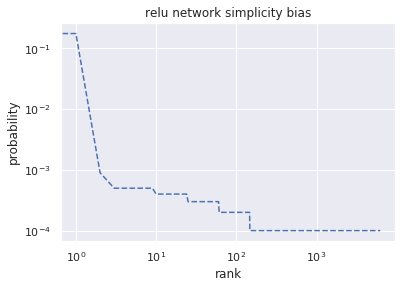

In [3]:
plt.plot(np.array(list(funfreq['relu'][2]), dtype='float')/ nsamples, '--', label='relu | 2 | 2')
plt.loglog()
plt.xlabel('rank')
plt.ylabel('probability')
plt.title('relu network simplicity bias')
plt.show()

Indeed, some functions are *way more* likely than others.

For example, what are the top 4 most frequent boolean functions? They are either constant functions or a single value different from one.

In [4]:
for boolfun, freq in funcounters['relu'][2].most_common()[:4]:
    print('function as a binary string:')
    print('\t', boolfun)
    print('frequency')
    print('\t', freq)

function as a binary string:
	 00000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000
frequency
	 1802
function as a binary string:
	 11111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111
frequency
	 1762
function as a binary string:
	 11111111111111111111111111111111111111111111111111111111111111111111110111111111111111111111111111111111111111111111111111111111
frequency
	 9
function as a binary string:
	 11101111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111
frequency
	 5


Hmm this is pretty interesting!
Would this phenomenon hold for architectures other than a 2 layer relu network?
For example, let's try some networks with sigmoid activations.
Here we will use `erf`, since we can do some spectral calculations for it later.

In [5]:
nsamples = 10**4
funcounters['erf'] = {}
funfreq['erf'] = {}
vb = 0
for vw in [1, 2, 4]:
    # `funcounters` holds a dictionary (more precisely, a `Counter` object) of boolean function (as a string) to its frequency
    funcounters['erf'][vw] = sample_boolean_fun(MyNet(Erf, WIDTHSPEC), vw, vb, nsamples, outformat='counter')
    # `funfreq` just has a list of frequencies
    funfreq['erf'][vw] = OD(funcounters['erf'][vw].most_common()).values()

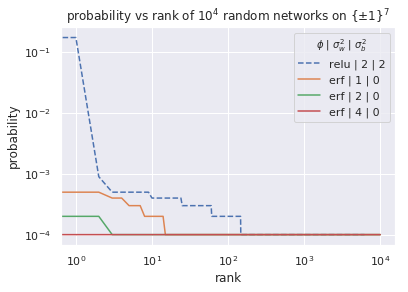

In [6]:
plt.plot(np.array(list(funfreq['relu'][2]), dtype='float')/ nsamples, '--', label='relu | 2 | 2')
plt.plot(np.array(list(funfreq['erf'][1]), dtype='float')/ nsamples, label='erf | 1 | 0')
plt.plot(np.array(list(funfreq['erf'][2]), dtype='float')/ nsamples, label='erf | 2 | 0')
plt.plot(np.array(list(funfreq['erf'][4]), dtype='float')/ nsamples, label='erf | 4 | 0')
plt.loglog()
plt.xlabel('rank')
plt.ylabel('probability')

plt.title(u'probability vs rank of $10^4$ random networks on $\{\pm1\}^7$')
plt.legend(title='$\phi$ | $\sigma_w^2$ | $\sigma_b^2$')
plt.show()

Looks like this "simplicity bias" is diminished when we use `erf`, and then goes away when we increase $\sigma_w^2$!
So it doesn't look like this "simplicity bias" is universal.
How can we understand this phenomenon better?
When can we expect "simplicity bias"?

# A Spectral Perspective on Simplicity Bias

*A priori*, the nonlinear nature seems to present an obstacle in reasoning about the distribution of random networks.
However, this question turns out to be more easily treated if we allow the *width to go to infinity*.
A long line of works starting with [Neal (1995)](http://www.cs.toronto.edu/~radford/bnn.book.html) and extended recently by [Lee et al. (2018)](https://openreview.net/forum?id=B1EA-M-0Z), [Novak et al. (2019)](https://arxiv.org/abs/1810.05148), and [Yang (2019)](https://arxiv.org/abs/1902.04760) has shown that randomly initialized, infinite-width networks are distributed as Gaussian processes.
These Gaussian processes also describe finite width random networks well as confirmed by [Valle-Pereze et al.](http://arxiv.org/abs/1805.08522) themselves.
We will refer to the corresponding kernels as the *Conjugate Kernels* (CK), following the terminology of [Daniely et al. (2017)](http://papers.nips.cc/paper/6427-toward-deeper-understanding-of-neural-networks-the-power-of-initialization-and-a-dual-view-on-expressivity.pdf).
Given the CK $K$, the simplicity bias of a wide neural network can be read off quickly from the *spectrum of $K$*:
If the largest eigenvalue of $K$ accounts for most of its trace, then a typical random network looks like a function from the top eigenspace of $K$.


More precisely, if we have the eigendecomposition 
\begin{equation}
K = \sum_{i \ge 1} \lambda_i u_i\otimes u_i
\label{eqn:eigendecomposition}
\end{equation}
with eigenvalues $\lambda_i$ in decreasing order and corresponding eigenfunctions $u_i$, then each sample (i.e. wide neural network) from this GP can be obtained as 
$$
\sum_{i \ge 1} \sqrt{\lambda_i} \omega_i u_i,\quad
\omega_i \sim \mathcal N(0, 1).
$$
If, for example, $\lambda_1 \gg \sum_{i \ge 2}\lambda_i$, then a typical sample function is just a very small perturbation of $u_1$.

This motivates us to take a look at the spectrum of the CK.

## A brief summary of the spectral theory of CK

Now, if the CK has spectra difficult to compute, then this perspective is not so useful.
But in idealized settings, where the data distribution is uniform over the boolean cube, the sphere, or from the standard Gaussian, a complete (or almost complete in the Gaussian case) eigendecomposition of the kernel can be obtained, thanks to the symmetry of the domain.
Of course, the probability-vs-rank experiment of Valle-Parez et al. is in this exact setting.
Here and in the paper, we focus on the boolean cube, since in high dimensions, all three distributions are very similar, and the boolean cube eigenvalues are much easier to compute (see paper for more details).

We briefly summarize the spectral theory of CK and NTK (of multilayer perceptrons, or MLPs) on the boolean cube.
First, these kernels are always diagonalized by the *boolean Fourier basis*, which are just monomial functions like $x_1 x_3 x_{10}$.
These Fourier basis functions are naturally graded by their *degree*, ranging from 0 to the dimension $d$ of the cube.
Then the kernel has $d+1$ unique eigenvalues,
$$\mu_0, \ldots, \mu_d$$
corresponding to each of the degrees, so that the eigenspace associated to $\mu_k$ is a $\binom d k$ dimensional space of monomials with degree $k$.
These eigenvalues are simple linear functions of a small number of the kernel values, and can be easily computed.

So let's compute the eigenvalues of the CK correponding to the architectures we've used above!

# Computing Eigenvalues over a Grid of Hyperparameters

Our methods for doing the theoretical computations lie in the `theory` module.

In [7]:
from theory import *

First, let's compute the eigenvalues of erf CK and NTK over these hyperparameters:

- $\sigma_w^2 \in \{1, 2, 4\}$
- $\sigma_b^2 = 0$
- dimension 7 boolean cube
- depth up to 100
- degree $k \le 7$.

In [8]:
erfvwrange = [1, 2, 4]
erfvbrange = [0]
s_erfvws, s_erfvbs = np.meshgrid([1, 2, 4], [0], indexing='ij')
dim = 7
depth = 100
maxdeg = 7

As mentioned in the paper, any CK or NTK $K$ of multilayer perceptrons (MLPs) takes the form
$$K(x, y) = \Phi\left(\frac{\langle x, y \rangle}{\|x\|\|y\|}, \frac{\|x\|^2}d, \frac{\|y\|^2}d\right)$$
for some function $\Phi: \mathbb R^3 \to \mathbb R$.
On the boolean cube $\{1, -1\}^d$, $\|x\|^2 = d$ for all $x$, and $\langle x, y \rangle / d$ takes value in a discrete set $\{-1, -1+2/d, \ldots, 1-2/d, 1\}$.
Thus $K(x, y)$ only takes a finite number of different values as well.
We first compute these values (see paper for the precise formulas).

In [9]:
# `erfkervals` has two entries, with keys `cks` and `ntks`, but the `ntks` entry is not relevant to us here
# Each entry is an array with shape (`depth`, len(erfvwrange), len(erfvbrange), `dim`+1)
# The last dimension carries the entries $\Phi(-1), \Phi(-1 + 2/d), ..., \Phi(1)$
s_erfkervals = boolcubeFgrid(dim, depth, s_erfvws, s_erfvbs, VErf, VDerErf)

The eigenvalues $\mu_k, k = 0, 1, \ldots, d$, can be expressed a simple linear function of $\Phi$'s values, as hinted before.
However, a naive evaluation would lose too much numerical precision because the number of alternating terms.
Instead, we do something more clever, resulting in the following algorithm:

- For $\Delta = 2/d$, we first evaluate $\Phi^{(a)}(x) = \frac 1 2 \left(\Phi^{(a-1)}(x) - \Phi^{(a-1)}(x - \Delta)\right)$ with base case $\Phi^{(0)} = \Phi$, for $a = 0, 1, \ldots$, and for various values of $x$.
- Then we just sum a bunch of nonnegative terms to get the eigenvalue $\mu_k$ associated to degree $k$ monomials
$$\mu_k = \frac 1{2^{d-k}} \sum_{r=0}^{d-k}\binom{d-k}r \Phi^{(k)}(1 - r \Delta).$$

Note that, here we will compute *normalized eigenvalues*, normalized by their trace.
So these normalized eigenvalues, with multiplicity, should sum up to 1.

In [10]:
s_erfeigs = {}
# `erfeigs['ck']` is an array with shape (`maxdeg`, `depth`+1, len(erfvwrange), len(erfvbrange))
# `erfeigs['ck'][k, L] is the matrix of eigenvalue $\mu_k$ for a depth $L$ erf network,
# as a function of the values of $\sigma_w^2, \sigma_b^2$ in `erfvwrange` and `erfvbrange`
# Note that these eigenvalues are normalized by the trace
# (so that all normalized eigenvalues sum up to 1)
s_erfeigs['ck'] = relu(boolCubeMuAll(dim, maxdeg, s_erfkervals['cks'], twostep=False))

This computes all we need for the erf kernels.
Now let's do the relu one.

In [11]:
s_reluvws, s_reluvbs = np.meshgrid([2], [1], indexing='ij')
dim = 7
depth = 2
maxdeg = 7

s_relukervals = boolcubeFgrid(dim, depth, s_reluvws, s_reluvbs, VReLU, VStep)

s_relueigs = {}
s_relueigs['ck'] = relu(boolCubeMuAll(dim, maxdeg, s_relukervals['cks'], twostep=False))

# A Spectral Explanation of the Simplicity Bias

In [12]:
def prunesmall(s, thr=1e-14):
    t = np.array(s)
    t[t<thr] = 0
    return t

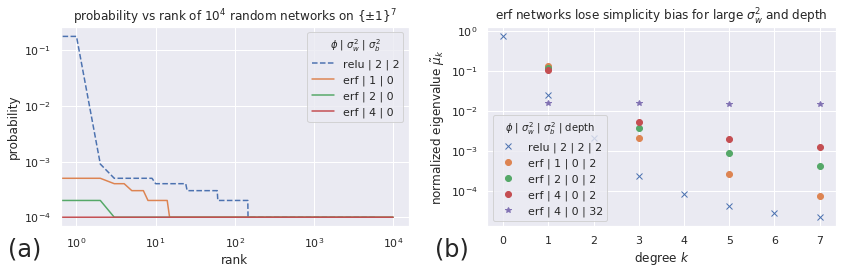

In [13]:
plt.figure(figsize=(12, 4.25))

ax0 = plt.subplot(121)
plt.plot(np.array(list(funfreq['relu'][2]), dtype='float')/ nsamples, '--', label='relu | 2 | 2')
plt.plot(np.array(list(funfreq['erf'][1]), dtype='float')/ nsamples, label='erf | 1 | 0')
plt.plot(np.array(list(funfreq['erf'][2]), dtype='float')/ nsamples, label='erf | 2 | 0')
plt.plot(np.array(list(funfreq['erf'][4]), dtype='float')/ nsamples, label='erf | 4 | 0')
plt.loglog()
plt.xlabel('rank')
plt.ylabel('probability')
ax0.text(-.15, -.15, '(a)', fontsize=24, transform=ax0.axes.transAxes)

plt.title(u'probability vs rank of $10^4$ random networks on $\{\pm1\}^7$')
plt.legend(title='$\phi$ | $\sigma_w^2$ | $\sigma_b^2$')


ax1 = plt.subplot(122)
plt.plot(prunesmall(s_relueigs['ck'][:, -1, 0, 0]), marker='x', linestyle='None', label=r'relu | 2 | 2 | 2')
for i in range(3):
    plt.plot(prunesmall(s_erfeigs['ck'][:, 2, i, 0]), marker='o', linestyle='None',
             label=r'erf | {} | 0 | 2'.format(2**i))
plt.plot(prunesmall(s_erfeigs['ck'][:, 32, -1, 0]), marker='*', linestyle='None', label=r'erf | 4 | 0 | 32')

plt.legend(title=r'$\phi$ | $\sigma_w^2$ | $\sigma_b^2$ | depth', loc='lower left')
plt.xlabel('degree $k$')
plt.ylabel(r'normalized eigenvalue $\tilde{\mu}_k$')
plt.title('erf networks lose simplicity bias for large $\sigma_w^2$ and depth')
plt.semilogy()
ax1.text(-.15, -.15, '(b)', fontsize=24, transform=ax1.axes.transAxes)

tight_layout(plt)

In **(a)**, we have reproduced the plot from above.
In **(b)** we have plotted the 8 unique (normalized) eigenvalues for the CK of each architecture given in the legend.

Immediately, we see that for relu and $\sigma_w^2 = \sigma_b^2 = 2$, the degree 0 eigenspace, corresponding to constant functions, accounts for more than $80\%$ of the variance.
This means that a typical infinite-width relu network of 2 layers is expected to be almost constant, and this should be even more true after we threshold the network to be a boolean function.
Indeed, this is exactly what we saw in [Section 2](#A-Quick-Replication-of-Valle-Perez-et-al.'s-Frequency-vs-Rank-Experiment)

On the other hand, for erf and $\sigma_b = 0$, the even degree $\mu_k$s all vanish, and most of the variance comes from degree 1 components (i.e. linear functions).
This concentration in degree 1 also lessens as $\sigma_w^2$ increases.
But because this variance is spread across a dimension 7 eigenspace, we don't see duplicate function samples nearly as much as in the relu case.
As $\sigma_w$ increases, we also see the eigenvalues become more equally distributed, which corresponds to the flattening of the probability-vs-rank curve in (a).

Finally, we observe that a 32-layer erf network with $\sigma_w^2 = 4$ has all its nonzero eigenvalues (associated to odd degrees) all equal (see points marked by $*$ in (b)).
This means that its distribution is a "white noise" on the space of *odd* functions, and the distribution of boolean functions obtained by thresholding the Gaussian process samples is the *uniform distribution* on *odd* functions.
This is the complete lack of simplicity bias modulo the oddness constraint.
Therefore, the simplicity bias is *really far away* from being universal to all neural networks, and seems more like a particular (nice) property of relu.

However, from the spectral perspective, there is a weak sense in which a simplicity bias holds for all neural network-induced CKs and NTKs.
We prove the following theorem in the paper.

**Theorem (Weak Spectral Simplicity Bias).**
Let $K$ be the CK of an MLP (with any nonlinearity) on a boolean cube $\{\pm1\}^d$.
Then the eigenvalues $\mu_k, k = 0, \ldots, d,$ satisfy
\begin{equation}
\mu_0 \ge \mu_2 \ge \cdots \ge \mu_{2k} \ge \cdots,\quad
\mu_1 \ge \mu_3 \ge \cdots \ge \mu_{2k+1} \ge \cdots.
\label{eqn:weaksimplicitybias}
\end{equation}

Even though it's not true that the fraction of variance contributed by the degree $k$ eigenspace is decreasing with $k$, the eigenvalue themselves will be in a nonincreasing pattern across even and odd degrees.
Of course, as we have seen, this is a *very weak* sense of simplicity bias, as it doesn't prevent "white noise" behavior as in the case of erf CK with large $\sigma_w^2$ and large depth.

# Conclusion

We have clarified the extent of "simplicity bias" in neural networks from the angle of eigendecomposition of the associated infinite-width conjugate kernel.
While this bias does not seem universal, it could still be that, architectures benefiting from a simplicity bias also do generalize better.
This would require some knowledge of the training of neural networks though.
Coincidentally, recent advances in deep learning theory have revealed that a different kernel, the *Neural Tangent Kernel*, in fact governs the evolution of NN gradient descent dynamics.
We discuss training and generalization from a spectral analysis of the NTK in the notebook *[Neural Network Generalization](NeuralNetworkGeneralization.ipynb)*, and more thoroughly in our full paper [*A Fine-Grained Spectral Perspective on Neural Networks*](https://arxiv.org/abs/1907.10599).